In [1]:
import matplotlib
import uproot, uproot3
import numpy
import awkward
import numba
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
from tqdm import trange
import ROOT
import os,sys
from array import array


from Lumi import *
from Ratio_Plot import *
from TDR_Style import *

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


Welcome to JupyROOT 6.24/06


In [3]:
def AddHist_data(file, hist, ptrange, isbarrel):
    branches = uproot.open(file+':Events').arrays(['More_than_three_tight_lep','HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ','HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8','HLT_Ele32_WPTight_Gsf','HLT_IsoMu24','photon_sieie','photon_vidNestedWPBitmap','photon_eta','photon_pt','photon_pfRelIso03_chg'], library='pd')
    
    HLT_SingleMuon = branches.loc[:,'HLT_IsoMu24'] == True
    HLT_DoubleMuon = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8'] == True
    HLT_EGamma = branches.loc[:,'HLT_Ele32_WPTight_Gsf'] == True
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    
    if 'SingleMuon' in file:
        arrays = branches.loc[HLT_SingleMuon, :].copy()
    elif 'DoubleMuon' in file:
        arrays = branches.loc[~HLT_SingleMuon & HLT_DoubleMuon, :].copy()
#         2018 is special
    elif 'EGamma' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &   (HLT_EGamma | HLT_DoubleEG) ,:].copy()
    elif 'MuonEG' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &  ~(HLT_EGamma | HLT_DoubleEG) & (HLT_MuonEG1 | HLT_MuonEG2),:].copy()
    else:
        arrays = branches.loc[HLT_SingleMuon | HLT_DoubleMuon |  HLT_EGamma | HLT_DoubleEG | HLT_MuonEG1 | HLT_MuonEG2,:].copy()
        
    
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
#         chg_cut = (arrays.loc[:,'photon_pfRelIso03_chg']*arrays.loc[:,'photon_pt']) < 1.141
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)
#         chg_cut = (arrays.loc[:,'photon_pfRelIso03_chg']*arrays.loc[:,'photon_pt']) < 1.051
        
    mask_mediumID_withoutsieie = (1<<1) | (1<<3) | (1<<5) | (1<<9) | (1<<11) | (1<<13)
    arrays['mediumID'] = arrays['photon_vidNestedWPBitmap'] & mask_mediumID_withoutsieie
    arrays = arrays.loc[arrays.loc[:,'mediumID'] == mask_mediumID_withoutsieie, :]
    
    three_lep_cut = arrays.loc[:,'More_than_three_tight_lep'] == 0
    
    
    if ptrange[1] == -1:
        pt_cut = (arrays.loc[:,'photon_pt'] >= ptrange[0])
    else:
        pt_cut = (arrays.loc[:,'photon_pt'] >= ptrange[0]) & (arrays.loc[:,'photon_pt'] < ptrange[1]) 
    arrays = arrays.loc[pt_cut & eta_cut & three_lep_cut,:]
    
    for i in trange(0, len(arrays['photon_sieie']), desc=f'fill sigma ieta ieta for {file}'):
        hist.Fill(float(arrays['photon_sieie'].values[i]))
    
    
def AddHist_mcTruth(file, hist, ptrange, isbarrel, xsec, lumi):
    branches = uproot.open(file+':Events').arrays(['Generator_weight','More_than_three_tight_lep','HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ','HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8','HLT_Ele32_WPTight_Gsf','HLT_IsoMu24','photon_sieie','photon_vidNestedWPBitmap','photon_genPartFlav','photon_eta','photon_pt','photon_pfRelIso03_chg'], library='pd')
    true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
    
    HLT_SingleMuon = branches.loc[:,'HLT_IsoMu24'] == True
    HLT_DoubleMuon = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8'] == True
    HLT_EGamma = branches.loc[:,'HLT_Ele32_WPTight_Gsf'] == True
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    
    arrays = branches.loc[HLT_SingleMuon | HLT_DoubleMuon |  HLT_EGamma | HLT_DoubleEG | HLT_MuonEG1 | HLT_MuonEG2,:].copy()
    
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)
        
    mask_mediumID_withoutsieie = (1<<1) | (1<<3) | (1<<5) | (1<<9) | (1<<11) | (1<<13)
    arrays['mediumID'] = arrays['photon_vidNestedWPBitmap'] & mask_mediumID_withoutsieie
    arrays = arrays.loc[arrays.loc[:,'mediumID'] == mask_mediumID_withoutsieie, :]
    
    three_lep_cut = arrays.loc[:,'More_than_three_tight_lep'] == 0
    
    if ptrange[1] == -1:
        pt_cut = (arrays.loc[:,'photon_pt'] >= ptrange[0])
    else:
        pt_cut = (arrays.loc[:,'photon_pt'] >= ptrange[0]) & (arrays.loc[:,'photon_pt'] < ptrange[1]) 
    gen_cut = arrays.loc[:,'photon_genPartFlav'] != 0
    arrays = arrays.loc[pt_cut & eta_cut & three_lep_cut & gen_cut,:]
    
    arrays['Generator_weight_sgn'] = arrays['Generator_weight'].apply(lambda x: 1 if x >= 0 else -1)
    arrays['true_weight'] = lumi * xsec * 1000 * arrays['Generator_weight_sgn'] / true_events
    
    for i in trange(0, len(arrays['photon_sieie']), desc=f'fill sigma ieta ieta for {file}'):
        hist.Fill(float(arrays['photon_sieie'].values[i]), float(arrays['true_weight'].values[i]))
        
    
def AddHist_dataFake(file, hist, ptrange, isbarrel,sb):
    branches = uproot.open(file+':Events').arrays(['More_than_three_tight_lep','HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ','HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8','HLT_Ele32_WPTight_Gsf','HLT_IsoMu24','photon_sieie','photon_vidNestedWPBitmap','photon_eta','photon_pt','photon_pfRelIso03_chg'], library='pd')
    
    HLT_SingleMuon = branches.loc[:,'HLT_IsoMu24'] == True
    HLT_DoubleMuon = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8'] == True
    HLT_EGamma = branches.loc[:,'HLT_Ele32_WPTight_Gsf'] == True
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    
    if 'SingleMuon' in file:
        arrays = branches.loc[HLT_SingleMuon, :].copy()
    elif 'DoubleMuon' in file:
        arrays = branches.loc[~HLT_SingleMuon & HLT_DoubleMuon, :].copy()
#         2018 is special
    elif 'EGamma' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &   (HLT_EGamma | HLT_DoubleEG) ,:].copy()
    elif 'MuonEG' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &  ~(HLT_EGamma | HLT_DoubleEG) & (HLT_MuonEG1 | HLT_MuonEG2),:].copy()
    else:
        arrays = branches.loc[HLT_SingleMuon | HLT_DoubleMuon |  HLT_EGamma | HLT_DoubleEG | HLT_MuonEG1 | HLT_MuonEG2,:].copy()
        
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)
        
    chg_cut = ((arrays.loc[:,"photon_pfRelIso03_chg"]*arrays.loc[:,"photon_pt"]) > sb[0]) & ((arrays.loc[:,"photon_pfRelIso03_chg"]*arrays.loc[:,"photon_pt"]) < sb[1])
    three_lep_cut = arrays.loc[:,'More_than_three_tight_lep'] == 0
    
    if ptrange[1] == -1:
        pt_cut = (arrays.loc[:,'photon_pt'] >= ptrange[0])        
    else:
        pt_cut = (arrays.loc[:,'photon_pt'] >= ptrange[0]) & (arrays.loc[:,'photon_pt'] < ptrange[1])
    
    arrays = arrays.loc[pt_cut & eta_cut & chg_cut & three_lep_cut,:]
    
    for i in trange(0, len(arrays['photon_sieie']), desc=f'fill sigma ieta ieta for {file}'):
        hist.Fill(float(arrays['photon_sieie'].values[i]))
        
# def FakeFraction_Fit(hist_data, hist_mcTruth, hist_dataFake):
    

In [6]:
def check_isbarrel(ptrange):
    if ptrange[-1]  == 0:
        return False
    else:
        return True

    
def set_xrange(isbarrel):
    xleft=0
    xright=0
    
    if isbarrel:
        xleft  = 0.006
        xright = 0.02
    else:
        xleft  = 0.01
        xright = 0.06
    return xleft,xright

In [4]:
filelist_data = [
"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018C.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018D.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MuonEG_Run2018A.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MuonEG_Run2018B.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MuonEG_Run2018C.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MuonEG_Run2018D.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/SingleMuon_Run2018A.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/SingleMuon_Run2018B.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/SingleMuon_Run2018C.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/SingleMuon_Run2018D.root"
]

filelist_mc = [
"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root"
]

In [5]:
filelist_MC = {
    
   "ZGToLLG":
        {"name":"ZGToLLG",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root", 
        "xsec":55.48,
        "color":48},
    "WZG":
        {"name":"WZG",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root",
        "xsec":0.0384,
        "color":46},
}

In [9]:
pt_dicts={
    "EB_PT1": [20,30,1],
    "EB_PT2": [30,50,1],
    "EB_PT3": [50,80,1],
    "EB_PT4": [80,120,1],
    "EB_PT5": [120,-1,1],
    "EE_PT1": [20,50,0],
    "EE_PT2": [50,-1,0]
}

closure_dict={
    "from_4_to_10":[4,10]
}

In [20]:
def Make_HistDict(template="Fake",xbins=5):
    if template=="Fake":
        
        # SB loop
        fake_hist_dict={}
        for sb_name,sb in closure_dict.items():
            print("start closure: {0}".format(sb_name))
            
            # PT loop
            pt_bin_hist_dict={}
            for ptname,ptrange in pt_dicts.items():
                print("start ptbins: {0}".format(ptname))
                
                isbarrel     = check_isbarrel(ptrange)
                xleft,xright = set_xrange(isbarrel)
                
                # file loop
                hist_datafake = ROOT.TH1F("","",xbins,xleft,xright)
                hist_datafake.Sumw2()
                for file in filelist_data:
                    AddHist_dataFake(file, hist_datafake, ptrange, ptrange[-1],sb)
                pt_bin_hist_dict[ptname] = hist_datafake
                
            fake_hist_dict[sb_name] = pt_bin_hist_dict
        return fake_hist_dict

    elif template=="Real":
        
        real_hist_dict={}
        for ptname,ptrange in pt_dicts.items():
            print("start ptbins: {0}".format(ptname))
            
            isbarrel     = check_isbarrel(ptrange)
            xleft,xright = set_xrange(isbarrel)
            
            # file loop
            hist_mctruth = ROOT.TH1F("","",xbins,xleft,xright)
            hist_mctruth.Sumw2()
            for file in filelist_MC:
                AddHist_mcTruth(filelist_MC[file]['path'], hist_mctruth, ptrange, isbarrel, filelist_MC[file]['xsec'], 59.7)
            real_hist_dict[ptname] = hist_mctruth
        return real_hist_dict
            
    elif template=="Data":
        
        data_hist_dict={}
        for ptname,ptrange in pt_dicts.items():
            print("start ptbins: {0}".format(ptname))
            
            isbarrel     = check_isbarrel(ptrange)
            xleft,xright = set_xrange(isbarrel)
            
            # file loop
            hist_data = ROOT.TH1F("","",xbins,xleft,xright)
            hist_data.Sumw2()
            for file in filelist_data:
                AddHist_data(file, hist_data, ptrange, isbarrel)
            data_hist_dict[ptname] = hist_data
        return data_hist_dict
    else:
        print("Wrong template")
    
hist_data_dict     = Make_HistDict("Data",5)
hist_mctruth_dict  = Make_HistDict("Real",5)
hist_datafake_dict = Make_HistDict("Fake",5)

np.save("data_hist_dict.npy",hist_data_dict)
np.save("real_hist_dict.npy",hist_mctruth_dict)
np.save("fake_hist_dict.npy",hist_datafake_dict)

start ptbins: EB_PT1


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 923/923 [00:00<00:00, 101716.83it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 449/449 [00:00<00:00, 117029.74it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 394/394 [00:00<00:00, 232394.29it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 1941/1941 [00:00<00:00, 133437.32it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 7097/7097 [00:00<00:00, 237092.60it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|█████████

start ptbins: EB_PT2


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 421/421 [00:00<00:00, 193343.04it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 216/216 [00:00<00:00, 177432.37it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 203/203 [00:00<00:00, 108671.82it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 960/960 [00:00<00:00, 236368.17it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 3036/3036 [00:00<00:00, 233226.01it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████|

start ptbins: EB_PT3


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 71/71 [00:00<00:00, 87125.68it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 32/32 [00:00<00:00, 76173.51it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 30/30 [00:00<00:00, 124091.83it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 175/175 [00:00<00:00, 129590.96it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 836/836 [00:00<00:00, 237065.66it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 424/424 [

start ptbins: EB_PT4


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 15/15 [00:00<00:00, 65672.82it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 8/8 [00:00<00:00, 45839.39it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 3/3 [00:00<00:00, 21183.35it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 21/21 [00:00<00:00, 101125.58it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 257/257 [00:00<00:00, 163200.02it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 141/141 [00:00<0

start ptbins: EB_PT5


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 6/6 [00:00<00:00, 39945.75it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 0it [00:00, ?it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 1/1 [00:00<00:00, 8793.09it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 7/7 [00:00<00:00, 45239.03it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 187/187 [00:00<00:00, 214827.40it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 86/86 [00:00<00:00, 190751.00it/s]
fill sigma ieta i

start ptbins: EE_PT1


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 165/165 [00:00<00:00, 213730.75it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 77/77 [00:00<00:00, 162373.76it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 78/78 [00:00<00:00, 183589.06it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 375/375 [00:00<00:00, 224022.79it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 1349/1349 [00:00<00:00, 231624.21it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 686

start ptbins: EE_PT2


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 13/13 [00:00<00:00, 43069.47it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 8/8 [00:00<00:00, 46995.00it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 6/6 [00:00<00:00, 36002.61it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 20/20 [00:00<00:00, 88674.50it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 154/154 [00:00<00:00, 160437.86it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 96/96 [00:00<00:0

start ptbins: EB_PT1


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root: 100%|██████████| 253/253 [00:00<00:00, 18578.04it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root: 100%|██████████| 936/936 [00:00<00:00, 73645.02it/s]


start ptbins: EB_PT2


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root: 100%|██████████| 145/145 [00:00<00:00, 115446.86it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root: 100%|██████████| 814/814 [00:00<00:00, 128380.97it/s]


start ptbins: EB_PT3


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root: 100%|██████████| 53/53 [00:00<00:00, 95325.09it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root: 100%|██████████| 363/363 [00:00<00:00, 123602.24it/s]


start ptbins: EB_PT4


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root: 100%|██████████| 19/19 [00:00<00:00, 59738.96it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root: 100%|██████████| 191/191 [00:00<00:00, 104967.51it/s]


start ptbins: EB_PT5


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root: 100%|██████████| 18/18 [00:00<00:00, 62549.69it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root: 100%|██████████| 208/208 [00:00<00:00, 119459.84it/s]


start ptbins: EE_PT1


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root: 100%|██████████| 48/48 [00:00<00:00, 55355.13it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root: 100%|██████████| 182/182 [00:00<00:00, 114584.71it/s]


start ptbins: EE_PT2


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root: 100%|██████████| 17/17 [00:00<00:00, 59271.13it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root: 100%|██████████| 91/91 [00:00<00:00, 89512.59it/s]


start closure: from_4_to_10
start ptbins: EB_PT1


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 291/291 [00:00<00:00, 212083.83it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 127/127 [00:00<00:00, 179958.31it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 122/122 [00:00<00:00, 111970.48it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 561/561 [00:00<00:00, 98349.20it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 2448/2448 [00:00<00:00, 94831.18it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 1

start ptbins: EB_PT2


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 106/106 [00:00<00:00, 189917.23it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 53/53 [00:00<00:00, 173534.83it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 38/38 [00:00<00:00, 131396.17it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 228/228 [00:00<00:00, 179216.89it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 1344/1344 [00:00<00:00, 209286.97it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 670

start ptbins: EB_PT3


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 22/22 [00:00<00:00, 76386.33it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 8/8 [00:00<00:00, 45282.63it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 8/8 [00:00<00:00, 52103.16it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 57/57 [00:00<00:00, 151122.20it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 495/495 [00:00<00:00, 181738.49it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 244/244 [00:00<0

start ptbins: EB_PT4


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 7/7 [00:00<00:00, 46309.35it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 5/5 [00:00<00:00, 32564.47it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 2/2 [00:00<00:00, 14513.16it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 21/21 [00:00<00:00, 34487.23it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 164/164 [00:00<00:00, 170221.69it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 82/82 [00:00<00:00,

start ptbins: EB_PT5


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 3/3 [00:00<00:00, 17975.59it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 1/1 [00:00<00:00, 8371.86it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 1/1 [00:00<00:00, 4315.13it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 5/5 [00:00<00:00, 12633.45it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 85/85 [00:00<00:00, 153670.62it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 34/34 [00:00<00:00, 66607

start ptbins: EE_PT1


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 72/72 [00:00<00:00, 151830.01it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 36/36 [00:00<00:00, 129720.74it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 18/18 [00:00<00:00, 49604.12it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 122/122 [00:00<00:00, 175783.27it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 588/588 [00:00<00:00, 219280.76it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 325/325 

start ptbins: EE_PT2


fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 7/7 [00:00<00:00, 42366.71it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 0it [00:00, ?it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 2/2 [00:00<00:00, 16545.58it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 9/9 [00:00<00:00, 54081.28it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 95/95 [00:00<00:00, 101803.50it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 40/40 [00:00<00:00, 126429.66it/s]
fill sigma ieta ie

---

## Load and Fit

Load hist

In [4]:
pt_dicts={
    "EB_PT1": [20,30,1],
    "EB_PT2": [30,50,1],
    "EB_PT3": [50,80,1],
    "EB_PT4": [80,120,1],
    "EB_PT5": [120,-1,1],
    "EE_PT1": [20,50,0],
    "EE_PT2": [50,-1,0]
}

closure_dict={
    "from_4_to_10":[4,10]
}

In [2]:
hist_data     = np.load("hist_dict_data.npy",allow_pickle=True)[()]['EE_PT1']
hist_mctruth  = np.load("hist_dict_real.npy",allow_pickle=True)[()]['EE_PT1']
hist_datafake = np.load("hist_dict_fake.npy",allow_pickle=True)[()]['from_4to10']['EE_PT1']

### Start Fit

In [11]:
ptrange      = pt_dicts['EE_PT1']
isbarrel     = check_isbarrel(ptrange)
xleft,xright = set_xrange(isbarrel)

In [7]:
# Observable
sieie = ROOT.RooRealVar("sieie","sieie",xleft,xright)


# Import hist
data_hist = ROOT.RooDataHist("data_hist", "data with x(sieie)", ROOT.RooArgList(sieie), ROOT.RooFit.Import(hist_data))
TruePhotons_hist = ROOT.RooDataHist("TruePhotons_hist", "true photons MC with x(sieie)", ROOT.RooArgList(sieie), ROOT.RooFit.Import(hist_mctruth))
FakePhotons_hist = ROOT.RooDataHist("FakePhotons_hist", "fake photons data with x(sieie)", ROOT.RooArgList(sieie), ROOT.RooFit.Import(hist_datafake))


xbins = hist_data.GetNbinsX()
print("bins :", xbins)

ndata = hist_data.GetSumOfWeights()

# Parameters
# TrueFraction = ROOT.RooRealVar("TrueFraction","fraction of true photons", 0, 1)
# FakeFraction = ROOT.RooRealVar("FakeFraction","fraction of fake photons", 0, 1)

ntrue = ROOT.RooRealVar("true number", "true number", 0.5*ndata, 0, ndata)
nfake = ROOT.RooRealVar("fake number", "fake number", 0.5*ndata, 0, ndata)

# PDF
true_pdf = ROOT.RooHistPdf("true_pdf", "truepdf", sieie, TruePhotons_hist)
fake_pdf = ROOT.RooHistPdf("fake_pdf", "fakepdf", sieie, FakePhotons_hist)

etrue_pdf = ROOT.RooExtendPdf("ntrue", "ntrue", true_pdf, ntrue)
efake_pdf = ROOT.RooExtendPdf("nfake", "nfake", fake_pdf, nfake)

fullpdf = ROOT.RooAddPdf("fullpdf", "true plus fake", ROOT.RooArgList(etrue_pdf, efake_pdf))

# Fit
fullpdf.fitTo(data_hist, ROOT.RooFit.SumW2Error(True), ROOT.RooFit.Extended(True))

chi2 = ROOT.RooChi2Var("chi2", "chi2", fullpdf, data_hist)
chi2ToNDF = chi2.getVal() / xbins


bins : 20
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data_hist): fit range of variable sieie expanded to nearest bin boundaries: [0.01,0.06] --> [0.01,0.062]
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (true_pdf,fake_pdf)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (ntrue,nfake)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 fake number   6.73900e+03  1.34780e+03    0.00000e+00  1.34780e+04
     2 true number   6.73900e+03  1.34780e+03    0.00000e+00  1.34780e+04
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 

### Plot1 : Berfore fit

bins : 20
59.7 fb^{-1} (13 TeV)


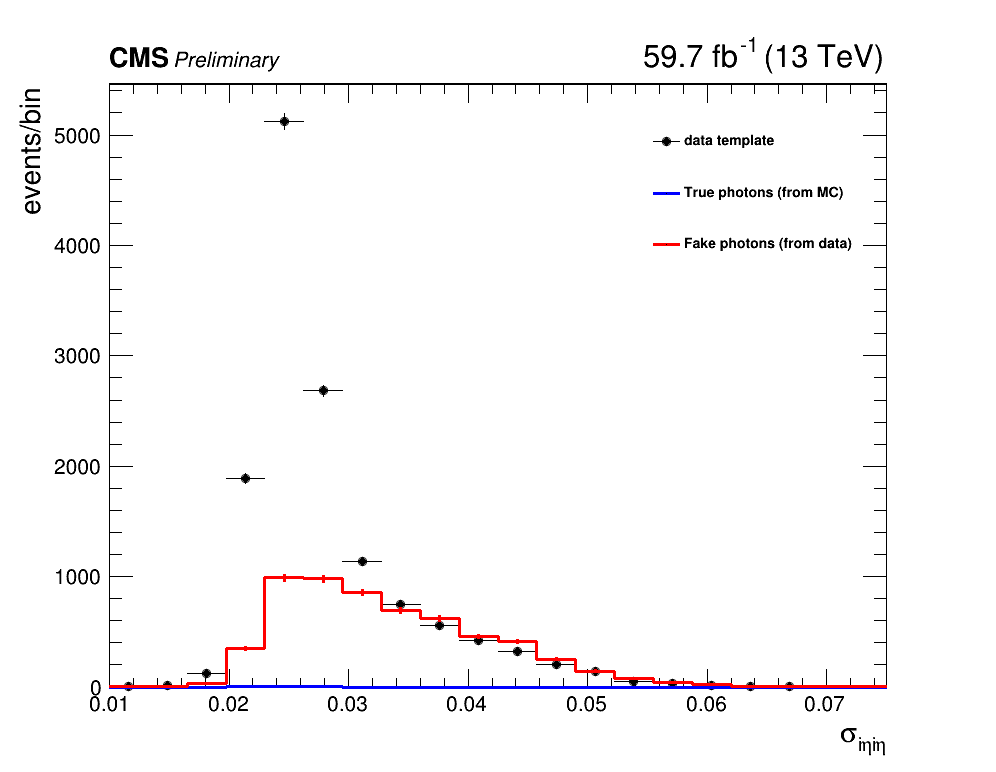

In [8]:
c1 = ROOT.TCanvas("","",1000,800)

xbins = hist_data.GetNbinsX()
print("bins :", xbins)

hist_data.SetStats(False)
c1.Draw()
hist_data.GetXaxis().SetTitle("#sigma_{i#etai#eta}")
hist_data.GetYaxis().SetTitle("events/bin")
hist_data.Draw("ep")

hist_mctruth.SetMarkerStyle(0)
hist_mctruth.SetLineColor(4)
hist_mctruth.SetLineWidth(3)
hist_mctruth.Draw("HiST SAME e")

hist_datafake.SetMarkerStyle(0)
hist_datafake.SetLineColor(2)
hist_datafake.SetLineWidth(3)
hist_datafake.Draw("HiST SAME e")



legend = ROOT.TLegend(0.65, 0.65, 0.80, 0.85)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.020)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
legend.AddEntry(hist_data,'data template')
legend.AddEntry(hist_mctruth,'True photons (from MC)')
legend.AddEntry(hist_datafake,'Fake photons (from data)')
legend.Draw("SAME")

# ROOT.gPad.SetLogy()
# ROOT.gPad.SetGrid()
CMS_lumi(c1, 0, 0)

### Plot2 : After fit

bins : 20
59.7 fb^{-1} (13 TeV)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(fullpdf) directly selected PDF components: (ntrue)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(fullpdf) indirectly selected PDF components: (true_pdf)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(fullpdf) directly selected PDF components: (nfake)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(fullpdf) indirectly selected PDF components: (fake_pdf)


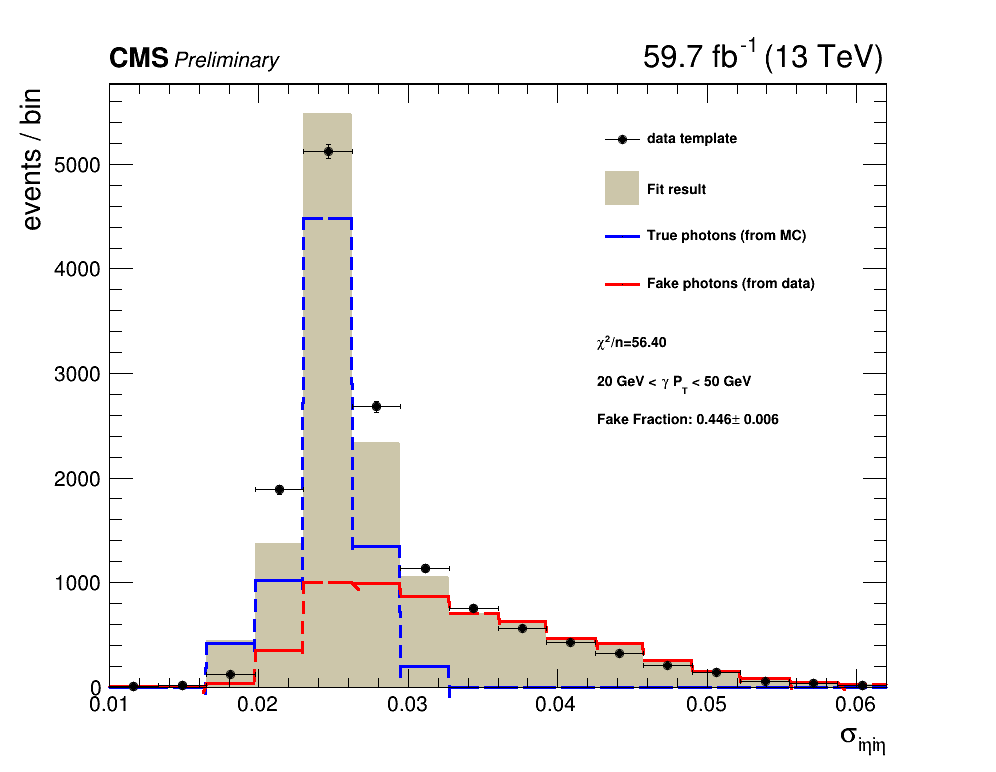

In [12]:
# Plot

xbins = hist_data.GetNbinsX()
print("bins :", xbins)

xframe = sieie.frame(ROOT.RooFit.Title(f"{region_mark} region, {ptrange[0]} GeV < photon PT < {ptrange[1]}"), ROOT.RooFit.Bins(xbins))
xframe.GetXaxis().SetTitle("#sigma_{i#etai#eta}")
xframe.GetYaxis().SetTitle("events / bin")
data_hist.plotOn(xframe)
fullpdf.plotOn(xframe, ROOT.RooFit.Name("sum"), ROOT.RooFit.FillStyle(4100), ROOT.RooFit.FillColor(20), ROOT.RooFit.DrawOption("F"))
fullpdf.plotOn(xframe, ROOT.RooFit.Components("ntrue"), ROOT.RooFit.Name("true"), ROOT.RooFit.LineColor(4), ROOT.RooFit.LineStyle(9))
fullpdf.plotOn(xframe, ROOT.RooFit.Components("nfake"), ROOT.RooFit.Name("fake"), ROOT.RooFit.LineColor(2), ROOT.RooFit.LineStyle(9))
data_hist.plotOn(xframe)



c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()
xframe.Draw()

legend = ROOT.TLegend(0.60, 0.60, 0.80, 0.85)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.020)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
legend.AddEntry(hist_data,'data template')
hist_fit_NaN = hist_data.Clone() # Just for plot
hist_fit_NaN.SetLineColor(20)
hist_fit_NaN.SetLineWidth(0)
hist_fit_NaN.SetFillColor(20)
hist_fit_NaN.SetMarkerStyle(0)
legend.AddEntry(hist_fit_NaN,'Fit result', "F")
legend.AddEntry(hist_mctruth,'True photons (from MC)')
legend.AddEntry(hist_datafake,'Fake photons (from data)')
legend.Draw("SAME")

textChi2 = ROOT.TLatex()
textChi2.SetNDC()
textChi2.SetTextSize(0.02)
textChi2.DrawLatex(0.6, 0.55, "#chi^{2}/n="+str("%.2f" % chi2ToNDF))
textChi2.DrawLatex(0.6, 0.50, str(ptrange[0])+" GeV < #gamma P_{T} < "+str(ptrange[1])+" GeV")
result_nfake = nfake.getVal()
result_nfake_err = nfake.getAsymErrorHi()
result_ntrue = ntrue.getVal()
result_ntrue_err = ntrue.getAsymErrorHi()
fake_fraction = result_nfake/(result_ntrue+result_nfake)
fake_fraction_err = numpy.sqrt(pow(result_nfake/pow(result_ntrue+result_nfake,2),2)*pow(result_ntrue_err,2) + pow(result_ntrue/pow(result_nfake+result_ntrue,2),2)*pow(result_nfake_err,2))
textChi2.DrawLatex(0.6, 0.45, "Fake Fraction: "+ str("%.3f" % fake_fraction) + "#pm " + str("%.3f" % fake_fraction_err)) 


CMS_lumi(c1, 0, 0)

# print (ntrue.getVal())
# print (ntrue.getAsymErrorHi())
# print (ntrue.getAsymErrorLo())